mean reversion algo

strat: we take a pos when the price moves 'too' far away from some kind o average

general idea is that it will move back toward the mean -at some point- (good in defined trends)

we can look at this strat with (4 example) linear regression, ma


In [7]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,5
import seaborn as sb
sb.set()

In [9]:
import json
import requests
import datetime as dt

url = 'https://api.binance.com/api/v3/klines'
symbol = 'BTCUSDT'
interval = '1d'
start = str(int(dt.datetime(2022,1,1).timestamp()*1000))  #data start from: 2017,8,16
end = str(int(dt.datetime(2023,1,30).timestamp()*1000))
par = {'symbol': symbol, 'interval': interval, 'startTime': start, 'endTime': end, 'limit': 5000}
btc = pd.DataFrame(json.loads(requests.get(url, params= par).text))
btc.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume','close_time', 'qav', 'num_trades','taker_base_vol', 'taker_quote_vol', 'ignore']
btc.drop(columns=['open', 'high', 'low', 'volume', 'close_time', 'qav', 'num_trades','taker_base_vol', 'taker_quote_vol', 'ignore'], inplace = True) #we will only use close price
btc.index = [dt.datetime.fromtimestamp(x/1000.0) for x in btc.datetime]
btc=btc.astype(float)
btc.head()

,datetime,close
2022-01-01 21:00:00,1.641082e+12,47286.18
2022-01-02 21:00:00,1.641168e+12,46446.10
2022-01-03 21:00:00,1.641254e+12,45832.01
2022-01-04 21:00:00,1.641341e+12,43451.13
2022-01-05 21:00:00,1.641427e+12,43082.31


adding more years of data (if==:0 -> we are looking only the data above ^^^^^^^^)

In [10]:
if==0: #delete this line run this cell
start = str(int(dt.datetime(2020,1,1).timestamp()*1000))
end = str(int(dt.datetime(2022,1,1).timestamp()*1000))
par = {'symbol': symbol, 'interval': interval, 'startTime': start, 'endTime': end, 'limit': 1000}
btc2 = pd.DataFrame(json.loads(requests.get(url, params= par).text))
btc2.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume','close_time', 'qav', 'num_trades','taker_base_vol', 'taker_quote_vol', 'ignore']
btc2.drop(columns=['open', 'high', 'low', 'volume', 'close_time', 'qav', 'num_trades','taker_base_vol', 'taker_quote_vol', 'ignore'], inplace = True) #we will only use close price
btc2.index = [dt.datetime.fromtimestamp(x/1000.0) for x in btc2.datetime]
btc2=btc2.astype(float)
btc2.head()

SyntaxError: invalid syntax (1919449311.py, line 1)

In [11]:
if==0: #delete this line to run this cell 
start = str(int(dt.datetime(2022,1,1).timestamp()*1000))
end = str(int(dt.datetime(2022,12,13).timestamp()*1000))
par = {'symbol': symbol, 'interval': interval, 'startTime': start, 'endTime': end, 'limit': 1000}
btc3 = pd.DataFrame(json.loads(requests.get(url, params= par).text))
btc3.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume','close_time', 'qav', 'num_trades','taker_base_vol', 'taker_quote_vol', 'ignore']
btc3.drop(columns=['open', 'high', 'low', 'volume', 'close_time', 'qav', 'num_trades','taker_base_vol', 'taker_quote_vol', 'ignore'], inplace = True) #we will only use close price
btc3.index = [dt.datetime.fromtimestamp(x/1000.0) for x in btc3.datetime]
btc3=btc3.astype(float)
btc3.head()

SyntaxError: invalid syntax (1690804058.py, line 1)

In [12]:
if==0: #delete this line to run this cell 
btc = btc.append(btc2)
btc = btc.append(btc3)

SyntaxError: invalid syntax (2072796118.py, line 1)

algo:

In [13]:
ma = 10
btc['returns'] = np.log(btc["close"]).diff()
btc['ma'] = btc['close'].rolling(ma).mean()
btc['ratio'] = btc['close'] / btc['ma']

In [14]:
percentiles = [3, 7.5, 50, 87.5, 91.5]
p = np.percentile(btc['ratio'].dropna(), percentiles)

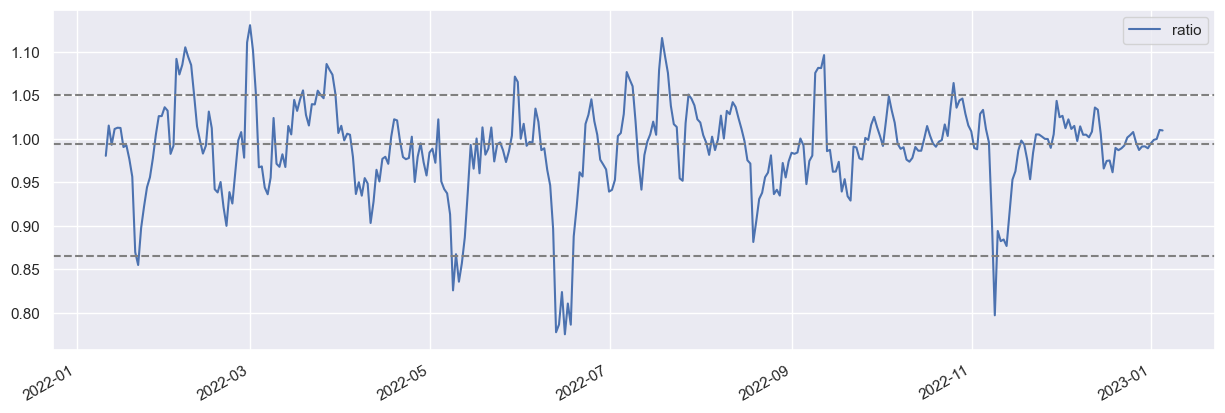

In [15]:
btc['ratio'].dropna().plot(legend = True)
plt.axhline(p[0], c= (.5,.5,.5), ls='--')
plt.axhline(p[2], c= (.5,.5,.5), ls='--')
plt.axhline(p[-1], c= (.5,.5,.5), ls='--');

positions

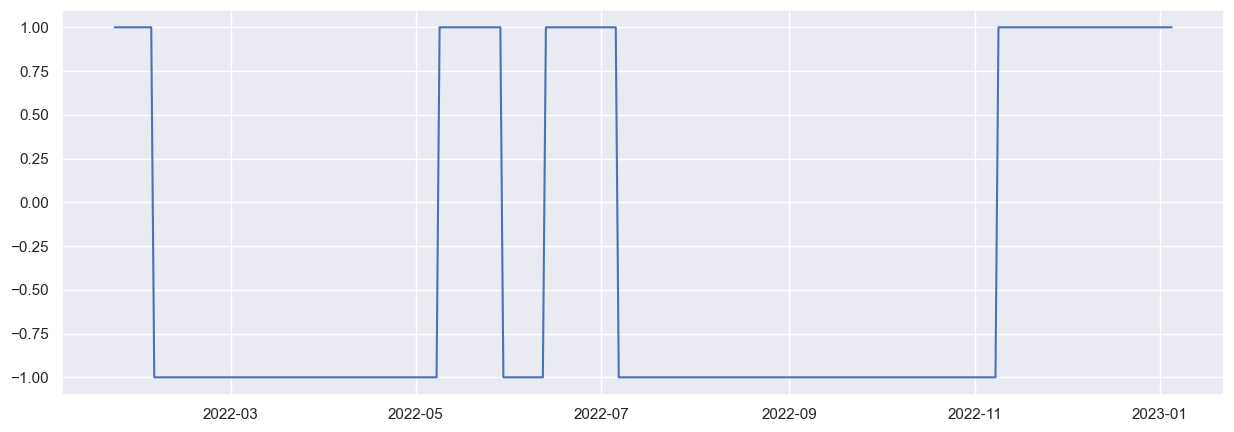

In [16]:
short = p[-1]
long = p[0]
btc['position'] = np.where(btc.ratio > short, -1, np.nan)
btc['position'] = np.where(btc.ratio < long, 1, btc['position'])
btc['position'] = btc['position'].ffill()
plt.plot(btc.position.dropna())

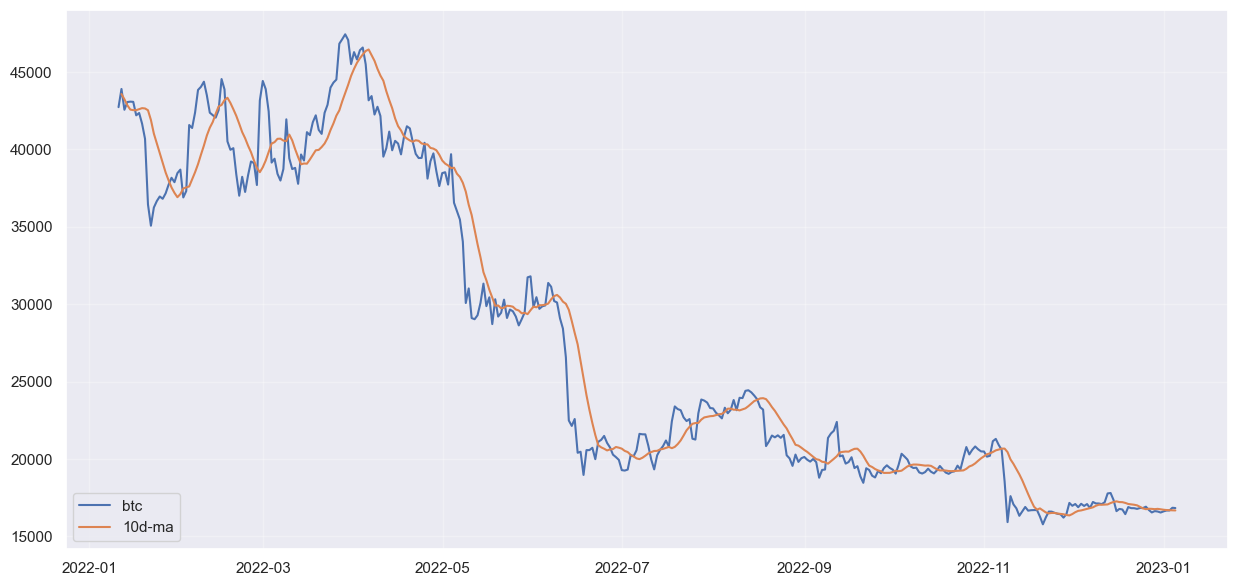

In [17]:
btc['10d-ma'] = btc['close'].rolling(10).mean().shift()
plt.rcParams['figure.figsize'] = 15, 7
plt.grid(True, alpha = .3)
plt.plot(btc.iloc[-360:]['close'], label = 'btc')
plt.plot(btc.iloc[-360:]['10d-ma'], label = '10d-ma')
plt.legend(loc=3);

performance

In [18]:
btc['algo_return'] = btc['returns'] * btc['position'].shift()

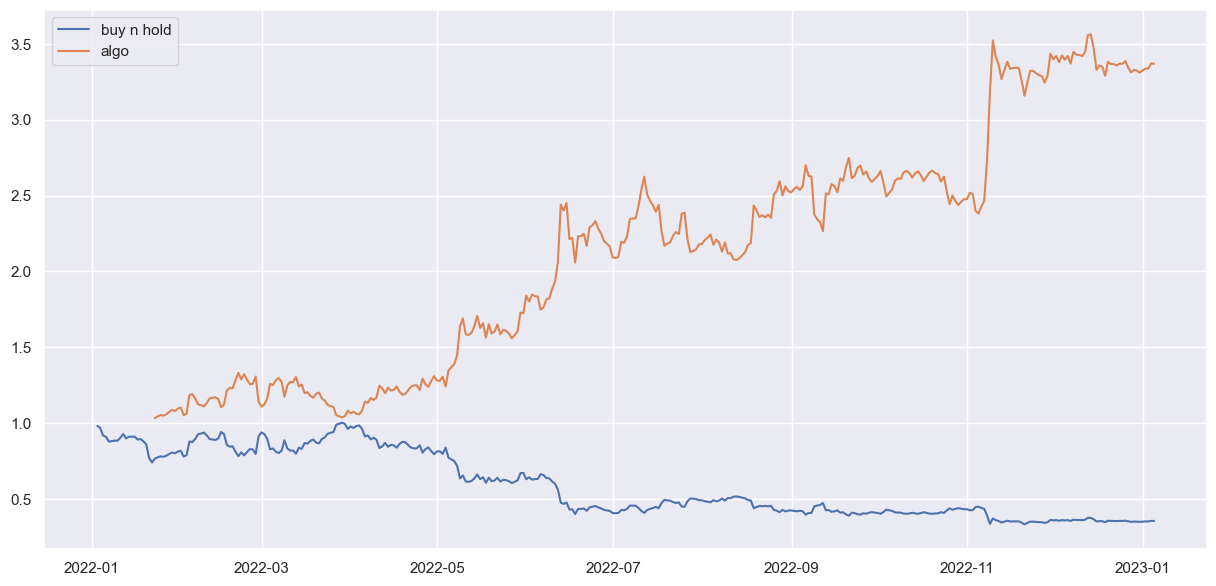

In [19]:
plt.plot(np.exp(btc['returns']).dropna().cumprod(), label='buy n hold' )
plt.plot(np.exp(btc['algo_return']).dropna().cumprod(), label='algo' )
plt.legend();

returns

buy n hold (%)

In [20]:
(np.exp(btc['returns']).dropna().cumprod()[-1] -1)*100

-64.4057100827345

system (%)

In [21]:
(np.exp(btc['algo_return']).dropna().cumprod()[-1] -1)*100

236.82920400697353